In [1]:
import numpy as np
import common

In [2]:
traj, xk, P, tau, rho, u, U, H, F, Q, N = common.init_all()

In [3]:
t = 0
x_log = []
P_log = []
for zk in traj.Y.T:
    #print('===== Step: ', t, '======') 
    t += 1
    
    #### Time update
    xk = common.predict_state(F, xk)
    P = common.predict_PECM(F, P, Q)
    
    #### Measurement update
    # Initialization - step 3
    tkk, Tkk, ukk, Ukk = common.init(P, tau, P.shape[0], rho, u, U.shape[0], U)
    
    ## VB iters
    Pik = P
    xikk = xk
    for i in range(N):
        # steps 4, 5
        err = np.atleast_2d(xikk - xk)
        Aik = Pik + err.dot(err.T)
        tik = tkk + 1
        Tik = Aik + Tkk
        
        # steps 6, 7
        err = np.atleast_2d(zk - H.dot(xikk))
        Bik = err.T.dot(err) + H.dot(Pik).dot(H.T)
        uik = ukk + 1
        Uik = Bik + Ukk
        
        # steps 8
        ERkinv = (uik - U.shape[0] - 1) * np.linalg.inv(Uik)
        EPkinv = (tik - P.shape[0] - 1) * np.linalg.inv(Tik)
        
        # steps 9
        Pik = np.linalg.inv(EPkinv)
        Rik = np.linalg.inv(ERkinv)
        
        # steps 10-12
        bracket = H.dot(Pik).dot(H.T) + Rik
        Kik = Pik.dot(H.T).dot(np.linalg.inv(bracket))
        xikk = xk + Kik.dot(zk - H.dot(xk))
        Pik = Pik - Kik.dot(H).dot(Pik)
    
    xk = xikk
    P = Pik
    Tkk = Tik
    u = uik
    U = Uik
    
    x_log.append(xk)
    P_log.append(P)
    
x_log = np.array(x_log).squeeze().T
P_log = np.array(P_log).squeeze()

In [4]:
# position: KF, just measurements
np.sqrt(((x_log[:2] - traj.X[:2]) ** 2 ).mean()), np.sqrt(((traj.Y[:2] - traj.X[:2]) ** 2 ).mean())

(0.5572290482045738, 0.7668096325216082)

In [5]:
# velocity: KF
np.sqrt(((x_log[2:] - traj.X[2:]) ** 2 ).mean())

1.0811931327580928

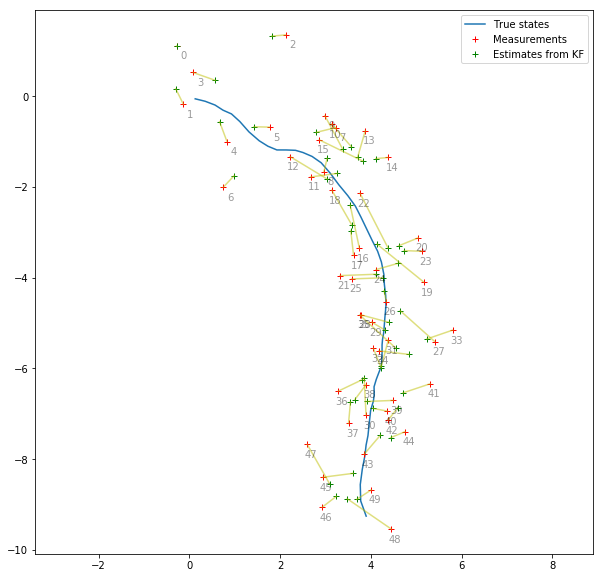

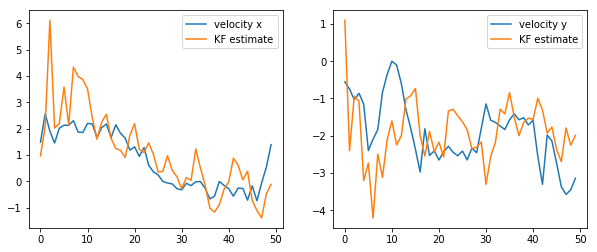

In [6]:
common.plot_results(traj, x_log)